# G02. 없다면 어떻게 될까? (ResNet Ablation Study)


## 2-1. 들어가며

![empty.max-800x600.jpg](Going_img/empty.max-800x600.jpg)


딥러닝 논문에서는 다양한 방법들을 적용하며, 그 방법 적용 전후의 차이를 실험 결과로 보여줍니다. 이때 논문에는 어느 정도 구현방법과 실험의 설정이 나와있으니, 하드웨어 자원을 엄청나게 필요로 하거나 특정한 데이터셋이 필요한 경우를 제외하면 어느 정도 따라해볼 수 있는데요. 평소 논문을 보고 이해하는 데 집중하셨다면, 이번 시간에는 모델을 구현하고, 모델에 각 기법을 적용했을 때와 아닐 때를 비교해 보면서 효과를 직접 체감해보는 시간을 갖도록 하겠습니다.

## 실습목표
***
1. 직접 ResNet 구현하기  
2. 모델을 config에 따라서 변경가능하도록 만들기  
3. 직접 실험해서 성능 비교하기  

### 학습내용
***
1. Ablation Study  
2. Back to the 2015  
3. Block  
4. Complete Model  
5. Experiment  


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ResNet 기본 블록 만들기
- 입력 인자
    - ```input_layer``` : 블럭 앞에 존재하는 입력층을 전달
    - ```num_cnn``` : 블럭 안에 Conv layer 수
    - 그 외에 ```channel``` 수와 몇번째 블럭인지 나타내는 ```block_num```
    - ```is_50``` : True = ResNet_50, False = ResNet_34
    - ```CHECK_CHANNEL``` : 함수 내부에서 채널이 바뀌면 input의 가로 세로 사이즈를 줄여주기 위해서 사용하는 변수
    - ```plain``` : plain net과 ResNet을 구분하는 변수

In [3]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                    is_50=False,
                    CHECK_CHANNEL=64,
                       plain=False,
                   ):
#     print(f'입력받은 shape : {input_layer.shape}')

    flag = CHECK_CHANNEL == channel
    bn = 1
    # 입력 레이어
    x = input_layer
    
    # 들어오는 input을 init_identity에 저장시켜 놓는다.
    # 이전 블럭에서 들어오는 정보는 init_identity에서 저장
    init_identity=x

    if not is_50:
        # CNN 레이어
        # 블럭 내부 구성
        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층 쌓기
            # 채널이 바뀌면서 이미지의 가로세로 길이가 반으로 줄어야 한다.
            # 채널.......으로 분기문을 주면...
            # 블럭안에서 Shortcut Connection으로 사용할 identity는 여기서 저장
            identity = x
            
            # flag가 False이면 새로운 Conv Block 쌓는다.
            # 그러므로 strides=(2,2)를 사용해서 입력이미지의 사이즈를 줄인다.
            if flag :
                # 첫번째 Conv
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            
            ######
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            
            ###########################
            
            # plain을 True로 주면 아래 shortcut connection을 만들지 않게된다.
            if not plain :
                
                # identity block
                # 채널이 바뀔 때 => identity block에서 strides를 2로 주면서
                # 그때 identity의 가로세로 사이즈를 줄여야한다
                # 맨 처음 입력이 될때는 어떻게 할 것인가? => 기존에 default 값을 64로 주어서 Flag를 True로 유지
                if flag :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                        name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True

                # AD
                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, init_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)
#################################################################### 
    # is_50 = Flase
    else:

        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층 쌓기
            identity = x
            
            if flag :
                 x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                

            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ######
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2',
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ### 3번째 Conv (앞에 채널의 4배)
            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv3'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ###########################
            
            # identity block
            # 채널이 바뀔 때 => identity block에서 strides를 2로 주면서
            # 그때 identity의 가로세로 사이즈를 줄여야한다
            # 맨 처음 입력이 될때는 어떻게 할 것인가? => 기존에 default 값을 64로 주면 될듯
            
            if not plain :
                
                if flag :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True


                # AD
                # 블럭의 첫번째 shortcut connection에서는 init_identity를 사용
                # 이후 shortcut connection에서는 블럭 내에서 생기는 identity를 사용
                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, init_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)
#################################################################### 

    return x, CHECK_CHANNEL

## ```build_resnet_block``` 동작 확인
- ```input_layer``` : shape는 (32, 32, 3)으로 사용
- 첫번재 블럭은 다음과 같이 설정
    - channel : 채널 수(64)
    - num_cnn : 한블럭안에 있는 [Conv layer*2] 의 갯수
    - block_num : 블럭의 수 (0)
- 아래 주석문들을 해제해서 블럭단위로 쌓을 수 있다.

### ResNet-34  : 블럭 생성 확인

In [4]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성

x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(resnet_input_layer)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(
    pool_size=(2, 2), 
    strides=2
)(x)

resnet_block_output, CHECK_CHANNEL = build_resnet_block(x, 
                                                        channel=64, 
                                                        num_cnn=3, 
                                                        block_num=0)

# resnet_block_output, CHECK_CHANNEL = build_resnet_block(resnet_block_output,
#                                          channel=128,
#                                          num_cnn = 4,
#                                          block_num=1,CHECK_CHANNEL=CHECK_CHANNEL)

# resnet_block_output, CHECK_CHANNEL = build_resnet_block(resnet_block_output,
#                                          channel=256,
#                                          num_cnn = 6,
#                                          block_num=2,CHECK_CHANNEL=CHECK_CHANNEL)

# resnet_block_output, CHECK_CHANNEL = build_resnet_block(resnet_block_output,
#                                          channel=512,
#                                          num_cnn = 3,
#                                          block_num=3,CHECK_CHANNEL=CHECK_CHANNEL)

resnet_block_output = keras.layers.AveragePooling2D(pool_size=(1,1))(resnet_block_output)
resnet_block_output = keras.layers.Flatten(name='flatten')(resnet_block_output)
resnet_block_output = keras.layers.Dense(10, activation='softmax', name='predictions')(resnet_block_output)

In [5]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### ResNet-50  : 블럭 생성 확인

In [6]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성

x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(resnet_input_layer)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(
    pool_size=(2,2), 
    strides=2
)(x)

resnet_block_output, CHECK_CHANNEL = build_resnet_block(x, 
                                                        channel=64, 
                                                        num_cnn=3, 
                                                        block_num=0,
                                                       is_50=True)

# resnet_block_output, CHECK_CHANNEL = build_resnet_block(resnet_block_output,
#                                          channel=128,
#                                          num_cnn = 4,
#                                          block_num=1,CHECK_CHANNEL=CHECK_CHANNEL,
#                                                        is_50=True)

# resnet_block_output, CHECK_CHANNEL = build_resnet_block(resnet_block_output,
#                                          channel=256,
#                                          num_cnn = 6,
#                                          block_num=2,CHECK_CHANNEL=CHECK_CHANNEL,
#                                                        is_50=True)

# resnet_block_output, CHECK_CHANNEL = build_resnet_block(resnet_block_output,
#                                          channel=512,
#                                          num_cnn = 3,
#                                          block_num=3,CHECK_CHANNEL=CHECK_CHANNEL,
#                                                        is_50=True)

resnet_block_output = keras.layers.AveragePooling2D(pool_size=(1,1))(resnet_block_output)
resnet_block_output = keras.layers.Flatten(name='flatten')(resnet_block_output)
resnet_block_output = keras.layers.Dense(10, activation='softmax', name='predictions')(resnet_block_output)

In [7]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [8]:
del model

# ResNet Build 하기 : ```build_resnet```
---
- ```assert``` ? [참고](https://wikidocs.net/21050)
    - 가정 설정문
    
        ```python
        a = 3
        assert a == 2
        ```
        ```python
        Traceback (most recent call last):
          File "<stdin>", line 1, in <module>
        AssertionError
        ```
    - 왜 필요한가?
        - 어떤 함수는 성능을 높이기 위해 반드시 정수만을 입력받아 처리하도록 만들 수 있다. 이런 함수를 만들기 위해서는 반드시 함수에 정수만 들어오는지를 확인할 필요가 있는데, 이를 위해 if문을 사용할 수도 있고 '예외 처리'를 사용할 수도 있지만 '가정 설정문'을 사용하는 방법도 있다.
          
    <br>  
- 입력 인자
    - ```input_shape``` : 입력 데이터의 shape
    - ```num_cnn_list``` : 각 블럭에서 cnn의 그룹(ResNet_34 = conv*2, ResNet_50 = conv*3)의 갯수가 담긴 list
    - ```channel_list``` : 각 블럭에서의 채널들이 담긴 list
    - ```num_classes``` : 분류할 모델의 class 수
    - ```is_50``` : 50과 34를 구분하는 boolean 변수
    - ```plain``` : ResNet과 PlainNet을 구분하는 boolean변수

In [9]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3, 4, 6, 3],
              channel_list=[64,128,256,512],
              num_classes=10,
                is_50=False,
                plain=False,):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape, name="input_layer")  # input layer를 만들어둡니다.
    output = input_layer # 뒤에서 사용하는 인자와 통일해주기 위해서 'output'이라고 한다
    
    output = keras.layers.Conv2D(
        filters=channel_list[0],
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(2,2), 
        strides=2,
        name='stage2_0_maxpooling'
    )(output)
    
    cc = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output, cc = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            CHECK_CHANNEL=cc,
            plain=plain
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [10]:
# 기본값을 그대로 사용해서 ResNet-34모델을 building한다.
resnet_34 = build_resnet()

resnet_34.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 16, 16, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 16, 64)   0           batch_normalization_2[0][0]      
_______________________________________________________________________________________

# ResNet-50
---
- ResNet-34와 다른점
    1. 기존의 블럭안에 있는 conv layer의 변화
        - 3x3 Conv layer가 두개가 아님
        - 1x1 Conv - 3x3 Conv - 1x1 Conv : 3개로
    2. 한 블럭의 채널수가 모두 동일한 것이 아니다
        - 각 블럭은 3개의 Conv층을 갖고 있고, 채널 수는 앞에 2개의 Conv 층은 같지만 마지막 Conv층은 기존 채널의 4배이다.
        - 64 -> 256, 128 -> 512, 256 -> 1024, 512 -> 2048
        ![image](https://user-images.githubusercontent.com/48716219/95995037-f33bbc80-0e6b-11eb-827d-3676476ef95e.png)


In [11]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_50 = build_resnet(
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64,128,256,512],
    is_50=True, 
)

resnet_50.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 16, 16, 64)   256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 16, 16, 64)   0           batch_normalization_3[0][0]      
_______________________________________________________________________________________

# 데이터셋 가져오기
---
- ```cats_vs_dogs``` 데이터를 사용
- ```ds_train```, ```ds_valid```, ```ds_test```를 ```8:1:1```의 비율로 나눈다
- ```ds_info.feature```확인

In [12]:
from tqdm.notebook import tqdm

In [13]:
BATCH_SIZE = 16
EPOCH = 10

In [14]:
(ds_train, ds_valid), ds_info = tfds.load(
    'cats_vs_dogs',
    split=[
        'train[:80%]',
        'train[80%:]',
    ],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [15]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/home/aiffel-dj56/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.68 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A C

In [16]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [17]:
ds_info.features["label"].num_classes, ds_info.features["label"].names

(2, ['cat', 'dog'])

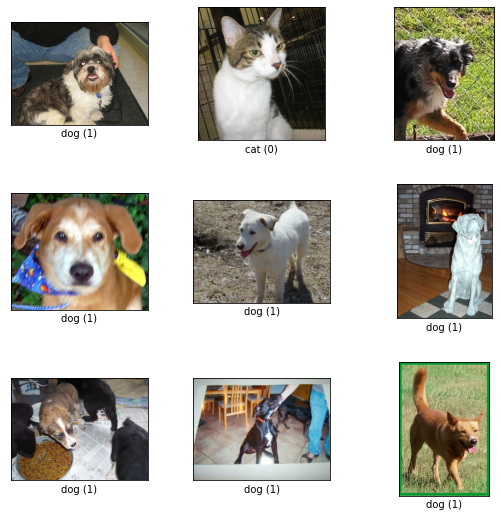

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

## 데이터 구성 확인
- ```ds_train```에는 두가지의 정보가 존재한다. (튜플로 담겨 있음)
    1. np.array의 이미지
    2. 이미지의 class -> 0(고양이), 1(개)
- 총 23262개의 데이터
    - ```ds_train``` : 18610
    - ```ds_valid``` : 2326
    - ```ds_test``` : 2326

In [19]:
# 데이터셋에서 데이터 하나 뽑기
img = next(iter(ds_train))

In [20]:
# 라벨 값을 출력해본다.
# 0 = 고양이, 1 = 개
img[1]

<tf.Tensor: shape=(), dtype=int64, numpy=1>

(500, 345, 3)


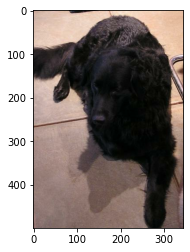

In [21]:
# 이미지 시각화
print(img[0].shape)
plt.imshow(img[0])
plt.show()

In [22]:
del img, fig

In [23]:
# 데이터의 개수도 확인해 봅시다. 
ds_train_len = 18610
ds_valid_len = 2326
ds_test_len = 2326
print(ds_train_len)
print(ds_valid_len)
print(ds_test_len)

18610
2326
2326


```python
import os
from glob import glob
import pandas as pd
###
path = os.path.join(os.getenv("HOME"), 'Desktop', 'cd')
train_paths = glob(os.path.join(path, 'train', '*'))
test_paths = glob(os.path.join(path, 'test1', '*'))
len(train_paths), len(test_paths)
###
classes = []

for path in tqdm(train_paths) :
	classes.append(path.split('/')[-1].split('.')[-3])

class_nums = tf.constant(np.unique(classes))
print(class_nums)
###
def read_image(path) :
    gfile = tf.io.read_file(path)
    image = tf.io.decode_jpeg(gfile, channels=3)
    
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, [128, 128])
    
    class_name = tf.strings.split(path, '/')[-1]
    class_name = tf.strings.split(class_name, '.')[-3]
    if class_name == 'cat':
        onehot = tf.constant([1], dtype=tf.uint8)
    else:
        onehot = tf.constant([0], dtype=tf.uint8)
    
#     onehot = tf.cast(class_nums == class_name, tf.uint8)
    
    return image, onehot
###
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(read_image)
train_ds = train_ds.shuffle(25000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.repeat()
##
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = test_ds.map(read_image)
test_ds = test_ds.shuffle(12500)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.repeat()


```

# 데이터 전처리
- [0, 1]의 범위로 정규화를 수행한다.
- shape는 (224, 224, 3)로 맞춰준다.
- batch단위로 묶어주기
- ```preprocess```함수
    - ```tf.dataset```을 입력으로 받는다
    - 이미지 리사이즈 : 224x224
    - 이미지 정규화
    - 전처리한 이미지와 label을 반환

### 각 데이터셋에 적용할 것들
- train 데이터에는?
    - preprocess
    - shuffle
    - repeat
    - batch
- valid 데이터에는?
    - preprocess
    - batch
    - repeat

In [24]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [25]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [26]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=16)

In [27]:
ds_valid = apply_normalize_on_dataset(ds_valid, is_test=False, batch_size=16)

```python
def preprocessing(img, label):
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.
    
    return img, label

ds_train = ds_train.map(preprocessing)

# 먼저 ds_train부터 수행
check = next(iter(ds_train))

# 라벨 확인
check[1]

# 이미지 확인
plt.imshow(check[0])
plt.show()

print(f'img의 shape : {check[0].shape}\n픽셀의 max값 : {np.max(check[0])}\n픽셀의 min값 : {np.min(check[0])}')

# 나머지 작업도 수행
# ds_train = ds_train.shuffle(ds_train_len)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.repeat()

# valid 데이터
ds_valid = ds_valid.map(preprocessing)
# ds_valid = ds_valid.shuffle(ds_valid_len)
ds_valid = ds_valid.batch(BATCH_SIZE)
ds_valid = ds_valid.repeat()

```

In [28]:
del resnet_34
del resnet_50

# 모델 생성 및 학습
---
1. ResNet-34
2. ResNet-50
3. PlainNet-34
4. PlainNet-50

### 그래프 비교함수 (```plot_loss_graph```, ```plot_acc_graph```)
- loss, accuracy

In [29]:
def plot_loss_graph(res, pla, num) :
    plt.plot(res.history['loss'], 'r')
    plt.plot(pla.history['loss'], 'b')
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

In [30]:
def plot_acc_graph(res, pla, num) :
    plt.plot(res.history['val_accuracy'], 'r')
    plt.plot(pla.history['val_accuracy'], 'b')
    plt.title('Model validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

### 모델
input_shape를 ```(224, 224, 3)```으로 하여서 위 4가지 모델을 새로 생성 후 학습을 진행

In [31]:
INPUT_SHAPE = (224, 224, 3)

In [32]:
resnet_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    plain=False,)

resnet_34.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 112, 112, 64) 256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_137 (Activation)     (None, 112, 112, 64) 0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

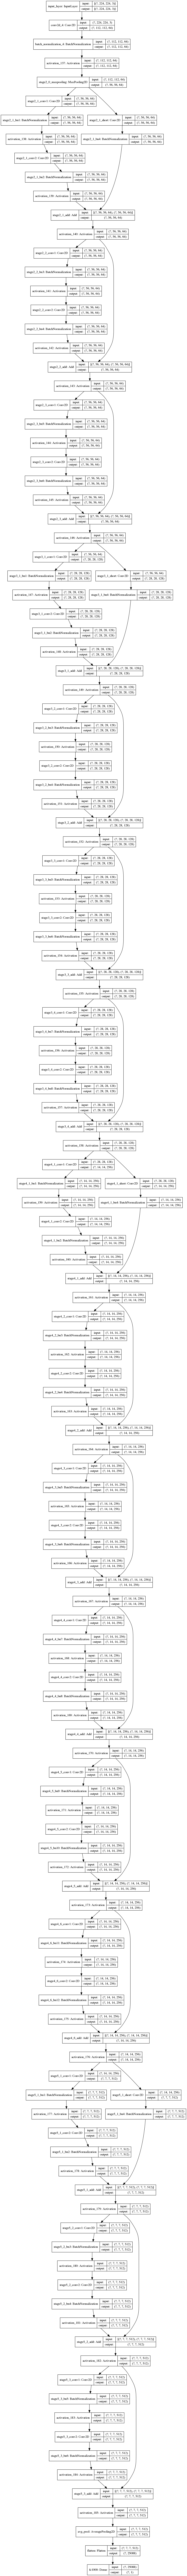

In [33]:
tf.keras.utils.plot_model(resnet_34, to_file='./resnet_34.png', show_shapes=True)

In [34]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), #, clipnorm=1.),
    metrics=['accuracy'],
)

res_history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
#     use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 109s 94ms/step - loss: 1.7016 - accuracy: 0.5267 - val_loss: 0.7374 - val_accuracy: 0.5293
Epoch 2/10
1163/1163 [==============================] - 94s 81ms/step - loss: 0.8362 - accuracy: 0.5924 - val_loss: 0.7481 - val_accuracy: 0.6379
Epoch 3/10
1163/1163 [==============================] - 94s 81ms/step - loss: 0.6419 - accuracy: 0.6727 - val_loss: 1.3201 - val_accuracy: 0.6707
Epoch 4/10
1163/1163 [==============================] - 93s 80ms/step - loss: 0.5622 - accuracy: 0.7199 - val_loss: 0.6951 - val_accuracy: 0.7220
Epoch 5/10
1163/1163 [==============================] - 95s 81ms/step - loss: 0.5257 - accuracy: 0.7429 - val_loss: 0.5995 - val_accuracy: 0.7306
Epoch 6/10
1163/1163 [==============================] - 95s 82ms/step - loss: 0.4891 - accuracy: 0.7668 - val_loss: 0.6869 - val_accuracy: 0.6685
Epoch 7/10
1163/1163 [==============================] - 93s 80ms/step - loss: 0.4406 - accuracy: 0.7963 - val_loss: 0.5351 

In [35]:
del resnet_34

plain_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    plain=True,)

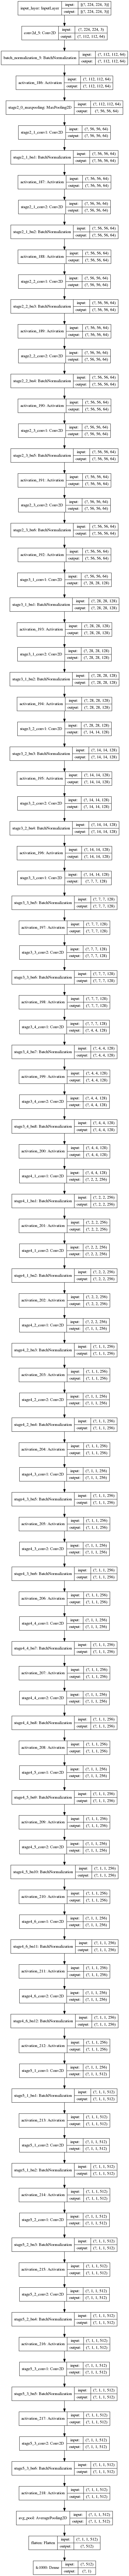

In [36]:
tf.keras.utils.plot_model(plain_34, to_file='./plain_34.png', show_shapes=True)

In [37]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), #, clipnorm=1.),
    metrics=['accuracy'],
)

pla_history_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.6944 - accuracy: 0.5746 - val_loss: 0.6905 - val_accuracy: 0.6216
Epoch 2/10
1163/1163 [==============================] - 79s 68ms/step - loss: 0.6843 - accuracy: 0.5587 - val_loss: 0.7008 - val_accuracy: 0.4862
Epoch 3/10
1163/1163 [==============================] - 65s 56ms/step - loss: 0.6865 - accuracy: 0.5546 - val_loss: 0.6817 - val_accuracy: 0.5263
Epoch 4/10
1163/1163 [==============================] - 65s 56ms/step - loss: 0.6873 - accuracy: 0.5547 - val_loss: 0.6952 - val_accuracy: 0.5030
Epoch 5/10
1163/1163 [==============================] - 65s 56ms/step - loss: 0.6913 - accuracy: 0.5508 - val_loss: 0.6958 - val_accuracy: 0.5435
Epoch 6/10
1163/1163 [==============================] - 65s 56ms/step - loss: 0.6926 - accuracy: 0.5216 - val_loss: 0.6923 - val_accuracy: 0.5082
Epoch 7/10
1163/1163 [==============================] - 66s 56ms/step - loss: 0.6989 - accuracy: 0.5039 - val_loss: 0.6939 -

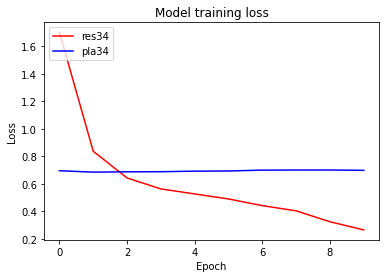

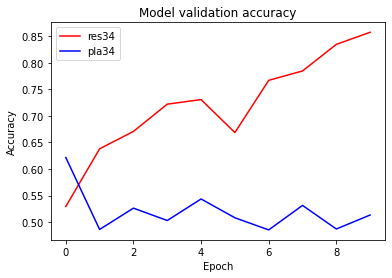

In [38]:
plot_loss_graph(res_history_34, pla_history_34, 34)
plot_acc_graph(res_history_34, pla_history_34, 34)

In [39]:
del plain_34
del pla_history_34
del res_history_34

In [40]:
resnet_50 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=True,
    plain=False,)

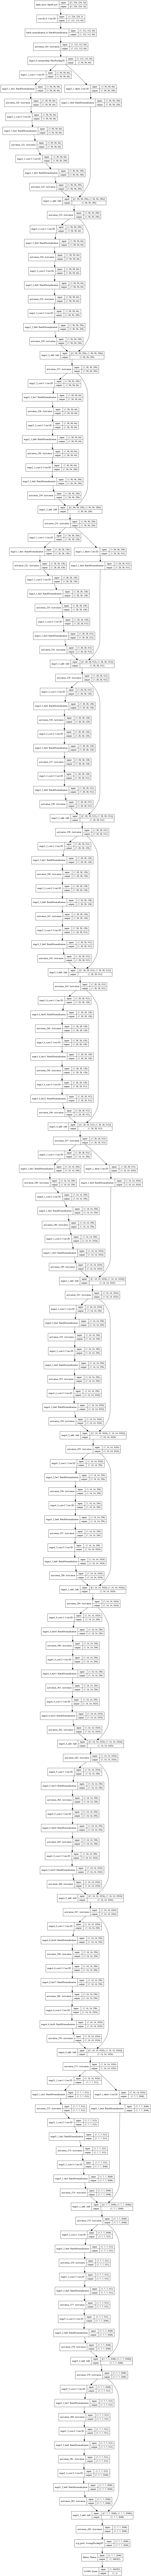

In [41]:
tf.keras.utils.plot_model(resnet_50, to_file='./resnet_50.png', show_shapes=True)

In [42]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), #, clipnorm=1.),
    metrics=['accuracy'],
)

res_history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 210s 181ms/step - loss: 3.3042 - accuracy: 0.5331 - val_loss: 6.1410 - val_accuracy: 0.5410
Epoch 2/10
1163/1163 [==============================] - 174s 150ms/step - loss: 0.9480 - accuracy: 0.6111 - val_loss: 1.2406 - val_accuracy: 0.6599
Epoch 3/10
1163/1163 [==============================] - 174s 150ms/step - loss: 0.8025 - accuracy: 0.6491 - val_loss: 1.8815 - val_accuracy: 0.5823
Epoch 4/10
1163/1163 [==============================] - 174s 150ms/step - loss: 0.6919 - accuracy: 0.6750 - val_loss: 0.8507 - val_accuracy: 0.6694
Epoch 5/10
1163/1163 [==============================] - 164s 141ms/step - loss: 0.6169 - accuracy: 0.6994 - val_loss: 7.9335 - val_accuracy: 0.5492
Epoch 6/10
1163/1163 [==============================] - 169s 146ms/step - loss: 0.6494 - accuracy: 0.6996 - val_loss: 0.6657 - val_accuracy: 0.7065
Epoch 7/10
1163/1163 [==============================] - 170s 146ms/step - loss: 0.5598 - accuracy: 0.7312 - val_

In [43]:
del resnet_50

plain_50 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=True,
    plain=True,)


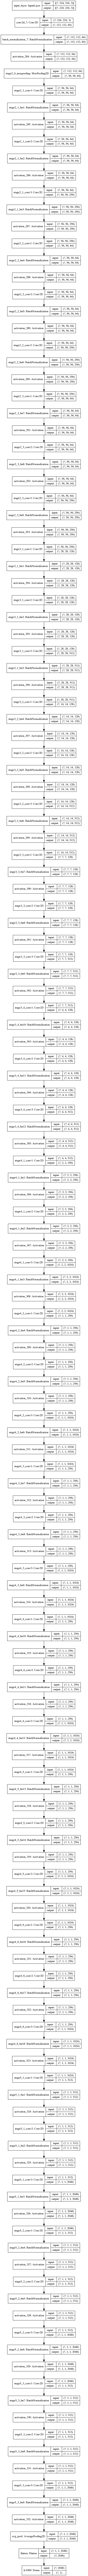

In [44]:
tf.keras.utils.plot_model(plain_50, to_file='./plain_50.png', show_shapes=True)

In [45]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), #, clipnorm=1.),
    metrics=['accuracy'],
)

pla_history_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 112s 97ms/step - loss: 0.7502 - accuracy: 0.5083 - val_loss: 6.4240 - val_accuracy: 0.5099
Epoch 2/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.7223 - accuracy: 0.5004 - val_loss: 2336.2324 - val_accuracy: 0.4957
Epoch 3/10
1163/1163 [==============================] - 85s 73ms/step - loss: 0.7280 - accuracy: 0.5006 - val_loss: 0.7106 - val_accuracy: 0.4978
Epoch 4/10
1163/1163 [==============================] - 90s 77ms/step - loss: 0.7176 - accuracy: 0.4994 - val_loss: 0.7185 - val_accuracy: 0.5073
Epoch 5/10
1163/1163 [==============================] - 82s 71ms/step - loss: 0.7139 - accuracy: 0.5022 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 6/10
1163/1163 [==============================] - 82s 71ms/step - loss: 0.7128 - accuracy: 0.5137 - val_loss: 0.6974 - val_accuracy: 0.4741
Epoch 7/10
1163/1163 [==============================] - 83s 71ms/step - loss: 0.7120 - accuracy: 0.5127 - val_loss: 0.84

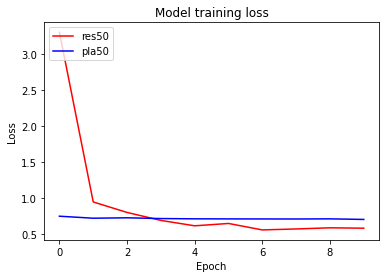

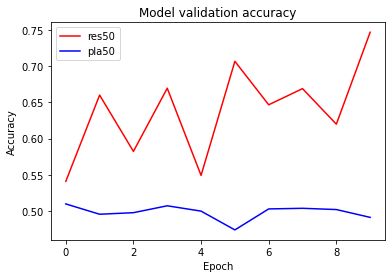

In [46]:
plot_loss_graph(res_history_50, pla_history_50, 50)
plot_acc_graph(res_history_50, pla_history_50, 50)

# 결과 정리

- 이미지를 (224, 224)로 resize를 해주었지만 메모리 용량이 부족했다. 다음과 같은 방법으로 해결했다.  
<br>  
    1. ```BATCH_SIZE```를 줄여준다 : 16까지 줄여준다.
    2. ```ds = ds.prefetch(tf.data.experimental.AUTOTUNE)``` 사용을 안한다.
        - prefetch를 하면 에폭이 끝나기 전에 메모리에 미리 데이터를 올려놓고 다음 에폭을 시작할 때 빠르게 진행하도록 해주는 것으로 알고 있다.
        - 이 기능을 사용하지 않고 커널이 죽는 현상을 막을 수 있었다.
    3. 중간중간에 ```del```을 사용해서 메모리를 계속해서 정리해준다.  
    <br>  
---
- ```ResNet34``` **vs** ```PlainNet34``` : Loss 값 변화
    ![image](https://user-images.githubusercontent.com/48716219/96059954-23b24380-0eca-11eb-8b61-afc2e2bc7cb5.png)
    - PlainNet34의 경우 Loss 값의 변화를 보면 학습이 진행되지 않은 것을 볼 수 있다.
    - 그에 반해 ResNet34는 Loss가 안정적으로 감소하고 있는 그래프를 보여주고 있고, 학습이 진행되고 있음을 알 수 있다.  
    <br>  
- ```ResNet50``` **vs** ```PlainNet50``` : Loss 값 변화
    ![image](https://user-images.githubusercontent.com/48716219/96060594-e64eb580-0ecb-11eb-9080-667a93c20556.png)
    - ```PlainNet50```의 그래프는 이전에 ```PlainNet34```와 비교했을 때도 볼 수 있듯이 이전보다 그래프의 변동폭이 매우 작고 학습이 전혀 진행되지 않는 모습을 볼 수 있다.
    - ```ResNet50```도 마찬가지로 ```PlainNet50```과 비교를 하면 Loss가 감소하면서 안정적으로 학습이 진행됨을 확인 할 수 있다.  
    <br>  
    
- ```ResNet34``` vs ```ResNet50``` : Validation Accurcay
    - 각각 ```0.6927```과 ```0.7194```의 score를 기록하였다.
    - 에폭이 10번밖에 수행밖에 안해서 그런지 크게 차이는 나지 않았다. 하지만 마지막 수치만 보았을 때는 ```ResNet50```의 값이 더 높았고, 층을 더 깊게 쌓은 ```ResNet50```의 경우에 Validation Accuracy가 안정적으로 증가하는 그림을 확인할 수 있었다.
    

### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

#### 평가문항/상세기준

1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?  
블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.


2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?  
cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.

 
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?  
ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

## 회고 및 고찰

Going Deeper로 들어와 처음 접하게 된 ResNet은 이상태에서 공부를 하는 것이 맞는 것인가에 대해서 회의감을 느끼게 되었다.  
그냥 하루 하루 버티기만 하면 어려운 모델도 이해할 수 있지 않을까 생각했던 것은 오산이었다.  
어려운 산인 만큼 미리고 미뤄서 정말 공부가 하기 싫었다.  
다행히 다른 기수에서 해결하신 예를 찾아서 차근히 따라가 볼 수 있었다. 이런 과정에서 나의 부족함과 앞으로 어떤 공부를 해나가야할지 민낮을 바라 볼 수 있는 기회가 되었다.  
앞으로 깊이 있게 실력을 갖출 수 있도록 많은 시간과 노력이 필요할 것으로 생각되었다. 
